<a href="https://colab.research.google.com/github/PuChan-HCI/myweb/blob/main/DeepLearning-with-Pytorch/05_U_Net_from_scratch_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building U-Net from Scratch
[Original Article](https://obgynai.com/unet-semantic-segmentation/)

こちらの記事ではU-Netを用いて、実際の細胞画像対してセグメンテーションを行う流れを解説させて頂きます。

この記事で扱うデータセットは多数の細胞核の画像です。これらの画像は撮影時のさまざまな条件下でデータが取得されています。そのため、データを確認すると、細胞の種類、倍率、およびイメージングモダリティが異なっている事が分かります。よって、これらの多種多様な画像を汎用的にセグメンテーションするというのはとても難度の高いタスクです。この記事ではその難度の高いタスクに対するU-Netモデルの有効性を確認することをゴールとて設定し、U-Netを学習する方の一助になればと思っています。

実装の流れとしては、ネット上でも良く取り扱われている他のチュートリアルとほぼ同様に、以下の流れで進めます。
1. データの確認、探索
2. データの前処理
3. U-Netのモデルの定義、トレーニング  
4. U-Netモデルの性能評価の確認

また、画像のアップロードや画像の処理やモデルのトレーニングを行う際に長い時間を要しますので、十分な時間を確保した上で以下を実行お願いします。モデルのトレーニングを行う場合はGPUの使用をお勧めします。Google Colabを使う場合は上部『ランタイム』タブから『ランタイムのタイプを変更』を選択し、ハードウェアアクセラレータをGPUに変更をお願いします。

## ①データの確認、探索

今回用いるデータセットはkaggleのコンペティションで用いられたデータセットを用います。
（https://www.kaggle.com/c/data-science-bowl-2018/data）

もし本記事に記載されているコードを実行する場合は、上のサイトから一度お使いのパソコンにデータセットをダウンロードし、そのデータセットをこのcolabノートブック上にアップロードする必要があります。

トレーニングデータのzipファイルであるstage1_train.zipをアップロードしてから以下を実行してください。(アップロードは10分ぐらい時間がかかりました。)

まず、zipファイルの解凍を行います。

In [ ]:
!unzip stage1_train.zip -d stage1_train

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: stage1_train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/160cf18b03df69978e2ed33335afcd781ebebf4ee42df566aaa6fd0aee66ac93.png  
  inflating: stage1_train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/16d3bf2426e9cda0e4f435de3a0c260d17be460f1c834c1282dfd68f9fcf7509.png  
  inflating: stage1_train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/1cfe69ef1dec8963e05ba8386a956af0073ba0bec2cc8ba534df81ef6dee905a.png  
  inflating: stage1_train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/1d2543cd2a8134ac2ca091a230bd15270826f8dd83c6594550b7f0fc85a15f8e.png  
  inflating: stage1_train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/24b50e6e3406e513d47ddfa9bd85505a95a266858cffc730a9ad7bc99936b800.png  
  inflating: stage1_train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/341193ff7f035f118eabe993464e402

In [ ]:
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 76.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.1
    Uninstalling albumentations-1.3.1:
      Successfully uninstalled albumentations-1.3.1


必要なライブラリをインポートしておきます。

In [ ]:
import os
import time
import copy
from collections import defaultdict
import torch
import shutil
import pandas as pd
from skimage import io, transform
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn
import albumentations as A
from albumentations.pytorch import ToTensorV2 as ToTensor
from tqdm import tqdm as tqdm

from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
import cv2

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
from PIL import Image
from torch import nn
import zipfile

import random

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
TRAIN_PATH = 'stage1_train/'

続いてデータセットの読み込みを行います。

ここでは前処理の一部である画像のリサイズと画像データ拡張も同時に行います。

画像のリサイズは様々なサイズの画像を全て固定のサイズに調整することにより1つのモデルによる対応が可能になります。

ここでは全ての画像を256×256の画像にリサイズしています。

また画像データ拡張は最近の画像系のディープラーニングの前処理とは一般的な処理で、画像に処理を加えることによりモデルの汎用化（予測精度を高める）ことが可能になります。

ここでは画像の正規化と水平垂直方向に画像をフリップさせる処理を追加しています。

「mask」はマスキング、つまり細胞のセグメンテーションがなされているデータであり、これが教師データとなります。

マスクに関しては今回は１つの細胞ごとに1つのファイルとなっているので、複数の画像を1つにまとめています。

トレーニングデータは一般的に入力画像と教師データ(mask)をペアとしてまとめ、このペアにより学習を行います。pytorchではこれらをDatasetクラスを用いてまとめます。

In [ ]:
#画像データ拡張の関数
def get_train_transform():
   return A.Compose(
       [
        #リサイズ(こちらはすでに適用済みなのでなくても良いです)
        A.Resize(256, 256),
        #正規化(こちらの細かい値はalbumentations.augmentations.transforms.Normalizeのデフォルトの値を適用)
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        #水平フリップ（pはフリップする確率）
        A.HorizontalFlip(p=0.25),
        #垂直フリップ
        A.VerticalFlip(p=0.25),
        ToTensor()
        ])

#Datasetクラスの定義
class LoadDataSet(Dataset):
        def __init__(self,path, transform=None):
            self.path = path
            self.folders = os.listdir(path)
            self.transforms = get_train_transform()

        def __len__(self):
            return len(self.folders)


        def __getitem__(self,idx):
            image_folder = os.path.join(self.path,self.folders[idx],'images/')
            mask_folder = os.path.join(self.path,self.folders[idx],'masks/')
            image_path = os.path.join(image_folder,os.listdir(image_folder)[0])

            #画像データの取得
            img = io.imread(image_path)[:,:,:3].astype('float32')
            img = transform.resize(img,(256,256))

            mask = self.get_mask(mask_folder, 256, 256 ).astype('float32')

            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            # mask = mask[0].permute(2, 0, 1)
            return (img,mask)

        #マスクデータの取得
        def get_mask(self,mask_folder,IMG_HEIGHT, IMG_WIDTH):
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
            for mask_ in os.listdir(mask_folder):
                    mask_ = io.imread(os.path.join(mask_folder,mask_))
                    mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
                    mask_ = np.expand_dims(mask_,axis=-1)
                    mask = np.maximum(mask, mask_)

            return mask

In [ ]:
train_dataset = LoadDataSet(TRAIN_PATH, transform=get_train_transform())

一枚の画像データとマスクの次元を確認します。

In [ ]:
image, mask = train_dataset.__getitem__(0)
print(image.shape)
print(mask.shape)

torch.Size([3, 256, 256])
torch.Size([256, 256, 1])


画像枚数を確認します。

In [ ]:
#Print total number of unique images.
train_dataset.__len__()

670

次に、入力画像とマスクのデータがどうなっているのか確認してみます。

[224, 301, 176]


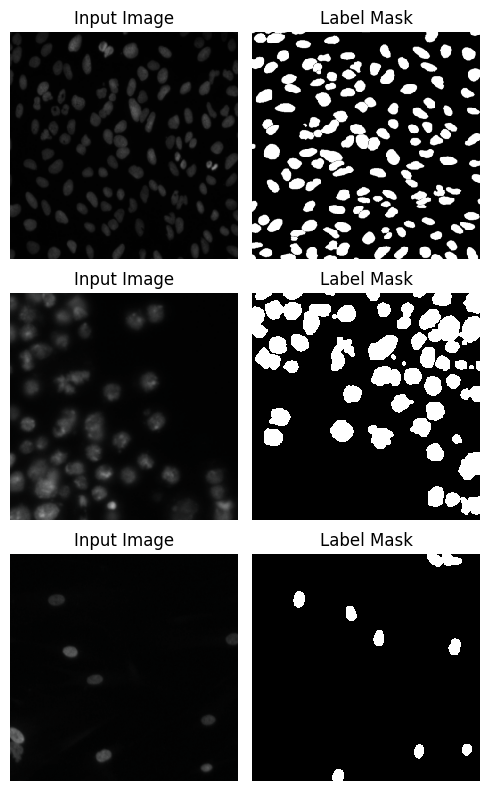

In [ ]:
def format_image(img):
    img = np.array(np.transpose(img, (1,2,0)))
    #下は画像拡張での正規化を元に戻しています
    mean=np.array((0.485, 0.456, 0.406))
    std=np.array((0.229, 0.224, 0.225))
    img  = std * img + mean
    img = img*255
    img = img.astype(np.uint8)
    return img
def format_mask(mask):
    mask = np.squeeze(np.transpose(mask, (1,2,0)))
    return mask

def visualize_dataset(n_images, predict=None):
  images = random.sample(range(0, 670), n_images)
  figure, ax = plt.subplots(nrows=len(images), ncols=2, figsize=(5, 8))
  print(images)
  for i in range(0, len(images)):
    img_no = images[i]
    image, mask = train_dataset.__getitem__(img_no)
    image = format_image(image)
    mask = format_mask(mask)
    ax[i, 0].imshow(image)
    ax[i, 1].imshow(mask, interpolation="nearest", cmap="gray")
    ax[i, 0].set_title("Input Image")
    ax[i, 1].set_title("Label Mask")
    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()
  plt.tight_layout()
  plt.show()
visualize_dataset(3)

左列が入力画像、右列がマスクデータとなっています。左列で細胞がある箇所に右列でマスクがなされていることが確認できます。U-Netは左の画像を入力した際に右のようなマスクされた画像データが出力できれば良いということになります。

## ②データの前処理

続いて評価データ作成のため、トレーニングデータの一部を評価データとして分割します。またpytorchではミニバッチ処理ができるようにDataLoaderクラスを作成します。

In [ ]:
split_ratio = 0.25
train_size=int(np.round(train_dataset.__len__()*(1 - split_ratio),0))
valid_size=int(np.round(train_dataset.__len__()*split_ratio,0))
train_data, valid_data = random_split(train_dataset, [train_size, valid_size])
train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)
val_loader = DataLoader(dataset=valid_data, batch_size=10)

print("Length of train　data: {}".format(len(train_data)))
print("Length of validation　data: {}".format(len(valid_data)))

Length of train　data: 502
Length of validation　data: 168


## ③ U-Netのモデルの定義、トレーニング
続いてU-Netのモデルを実装します。モデルについては[解説記事](https://www.researchgate.net/figure/U-net-Convolutional-Neural-Network-model-The-U-net-model-contains-two-parts_fig6_317493482)をご参照ください。こちらを元に実装をしていきます。

U-Netモデルにおいては細かい構成というよりはモデルの全体構成から把握していった方が理解がしやすいと思いました。U-Net解説記事にも記載してあります通り、
1. FCNにあたる部分、
2. Up Samplingにあたる部分、
3. Skip Connectionにあたる部分
をまず把握します。

以下のコードコメント文にそれぞれがどこに該当するかを記載しています。
- Skip Connectionはtorch.catによりFCN時の出力と合わせています。
- conv_bn_relu関数は畳み込みとバッチ正規化と活性化関数Reluをまとめています。

PyTorchでは通常モデル作成の際に，Moduleクラスを継承します．これにより，PyTorchフレームワークにより誤差伝搬によるパラメータ更新などが容易にできます．ここでは，U=Netに用いる層を定義します．conv_bn_relu, up_pooling, down_poolingは特定の層をグループ化したものです．nn.Maxpool2dはMaxPoolingになります．

前半の層の定義部分がU-Netでの「FCNに当たる部分」（エンコーダとも呼ばれます），後半の定義部分がU-Netでの「Up-Samplingにあたる部分」（デコーダとも呼ばれます）になります．

forwardメソッドには，順伝搬の処理を記載します．先ほど定義した層の関数を用いて，論文の通りに層を並べています．
- 前半のFCNの部分は論文の通り，畳み込みを行う関数（conv）とプーリングを行う関数（p）が交互になっています．
- 後半のUp_Samplingの部分は畳み込みを行う関数（conv）とアッププーリングを行う関数（up_pool）が交互になっており，cat関数により，FCN部分を連結していることが分かります．これがSkip_Connectiuonの部分になります．
- 最後はsigmoid関数にかけて，出力を0~1の範囲にしています．

![Floating point](https://puchan-hci.github.io/myweb/DeepLearning-with-Pytorch/img/03-3.jpg)

In [ ]:
# UNet
class UNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        # 資料中の『FCN』に当たる部分
        self.conv1 = conv_bn_relu(input_channels,64)
        self.conv2 = conv_bn_relu(64, 128)
        self.conv3 = conv_bn_relu(128, 256)
        self.conv4 = conv_bn_relu(256, 512)
        self.conv5 = conv_bn_relu(512, 1024)
        self.down_pooling = nn.MaxPool2d(2)

        # 資料中の『Up Sampling』に当たる部分
        self.up_pool6 = up_pooling(1024, 512)
        self.conv6 = conv_bn_relu(1024, 512)
        self.up_pool7 = up_pooling(512, 256)
        self.conv7 = conv_bn_relu(512, 256)
        self.up_pool8 = up_pooling(256, 128)
        self.conv8 = conv_bn_relu(256, 128)
        self.up_pool9 = up_pooling(128, 64)
        self.conv9 = conv_bn_relu(128, 64)
        self.conv10 = nn.Conv2d(64, output_channels, 1)

        # ここは重みパラメータの初期化処理
        # これをやらないと，学習が収束しない
        # https://qiita.com/siruku6/items/5435f4e52c9cfa6cdda4
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_out')
                if m.bias is not None:
                    m.bias.data.zero_()

        # 解説 1：self.modulesには、各層がmodule化されて入っています。
        # nn.Sequentials(
            # nn.Conv2d(...),   ⇒ 1ループ目
            # nn.ReLU(...),     ⇒ 2ループ目
            # nn.Conv2d(...),   ⇒ 3ループ目
            # ...
        # )
        #
        # 解説 2：isinstanceは、pythonの組み込み関数です．
        # このmが、 Conv2d BatchNorm2d Linear のいずれかから作られた
        # インスタンスだったときだけ if条件がTrue になります。
        #
        # 解説 3：kaiming_normal_は、第一引数に与えた Tersor型のパラメータを
        # 初期化 してくれます。
        # 'fan_in'の場合は、一つ前の層の分散の大きさが維持されるように、
        # モデルパラメータを初期化するよ。
        # 'fan_out'の場合は、一つ後ろの層の分散の大きさが維持されるように
        # モデルパラメータを初期化する．

)

    def forward(self, x):
        # 正規化
        x = x/255.

        # 資料中の『FCN』に当たる部分
        x1 = self.conv1(x)
        p1 = self.down_pooling(x1)
        x2 = self.conv2(p1)
        p2 = self.down_pooling(x2)
        x3 = self.conv3(p2)
        p3 = self.down_pooling(x3)
        x4 = self.conv4(p3)
        p4 = self.down_pooling(x4)
        x5 = self.conv5(p4)

        # 資料中の『Up Sampling』に当たる部分, torch.catによりSkip Connectionをしている
        p6 = self.up_pool6(x5)
        x6 = torch.cat([p6, x4], dim=1)
        x6 = self.conv6(x6)

        p7 = self.up_pool7(x6)
        x7 = torch.cat([p7, x3], dim=1)
        x7 = self.conv7(x7)

        p8 = self.up_pool8(x7)
        x8 = torch.cat([p8, x2], dim=1)
        x8 = self.conv8(x8)

        p9 = self.up_pool9(x8)
        x9 = torch.cat([p9, x1], dim=1)
        x9 = self.conv9(x9)

        output = self.conv10(x9)
        output = torch.sigmoid(output)

        return output

#畳み込み（Conv2d）とバッチ正規化（BatchNorm2d）と活性化関数（Relu）をまとめている
def conv_bn_relu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
    )

# down_poolingとしてMaxPoolingを利用
def down_pooling():
    return nn.MaxPool2d(2)

# up_poolingは転置畳み込み処理（ConvTranspose2d），バッツ正規化（BatchNorm2d），活性化関数（ReLu）をまとめている．
def up_pooling(in_channels, out_channels, kernel_size=2, stride=2):
    return nn.Sequential(
        #転置畳み込み
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

## 損失関数について
セマンティックセグメンテーションの損失関数としてはBCELoss(Binary Cross Entropy)をベースとしたDiceBCELossがよく用いられます。詳細な説明とコードはこの[記事](https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch)があります。
考え方としてはIoUに近く、予測した範囲が過不足なく教師データとなる領域を捉えているほど損失が低くなります。

![Floating point](https://puchan-hci.github.io/myweb/DeepLearning-with-Pytorch/img/03-4.jpg)

ちなみに，dice_lossを計算する際に，smoothという変数が計算の際に加えられたいますが，これは分子分母が0になった際に，dice_lossの値が無限大に発散勾配爆発を防ぐために加えています．また，PyTorchでは損失関数をカスタムで定義する場合は，nn.Moduleを継承します．これにより，forwardで返された損失の値によりパラメータ更新する計算をPyTorchフレームワークにより自動で行ってくれます．コード中の変数はinputsがもでるによるマスク領域の出力，targetsが教師データによるマスク領域となります．

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

セマンティックセグメンテーションの精度評価指標となるIoUのクラスを定義します．こちらは先ほど同様に図を見ていただいた方が分かりやすいと思います．

![Floating point](https://puchan-hci.github.io/myweb/DeepLearning-with-Pytorch/img/03-5.jpg)

こちらも計算の際にsmoothという変数が計算に加えられており，分子分母が0に近い数になった際にIoUの値が無限大に発散するのを防ぎます．なお，inputsがモデルによるマスク領域の出力，targetsが教師データによるマスク領域となります．

In [ ]:
class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return IoU

続いてモデルを保存，ロードするための関数を定義します．

In [ ]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    f_path = checkpoint_path
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_path
        shutil.copyfile(f_path, best_fpath)

def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    valid_loss_min = checkpoint['valid_loss_min']
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

if not os.path.exists("model"):
    os.makedirs("model")

続いてU-Netの学習を行います。

まずは，モデル，オプティマイザ，損失関数のインスタンス作成を行います．
- 1エポックごとに，評価データによる精度評価を行い，その結果による最高のモデルをbest_model_pathに保存する形になっています．
- パラメータ最適化アルゴリズムはAdamを指定しますが，これは最近としては定番となっています．
- criterionは用いる損失関数で上記で定義したDiceBCELoss，精度評価指標は先ほど定義したIoUを指定します．

学習の流れとしては，ミニバッチ数のデータをモデルに通して出力を得て，教師データとの差（loss）をDiceBCELossによい求め，そのlossによりパラメータ更新をAdamによって行うという流れになります．エポックが終わる度に，評価データを使ってIoUを評価します．

また，学習と評価と共に，エポックごとのlossの値を保存しておき，評価でのlossが最も少ないモデルパラメータをbest_model_pathに保存しています．


In [ ]:
#<---------------各インスタンス作成---------------------->
model = UNet(3,1).cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
criterion = DiceLoss()
accuracy_metric = IoU()
num_epochs=20
valid_loss_min = np.Inf

checkpoint_path = 'model/chkpoint_'
best_model_path = 'model/bestmodel.pt'

total_train_loss = []
total_train_score = []
total_valid_loss = []
total_valid_score = []

losses_value = 0
for epoch in range(num_epochs):
  #<---------------トレーニング---------------------->
    train_loss = []
    train_score = []
    valid_loss = []
    valid_score = []
    pbar = tqdm(train_loader, desc = 'description')
    for x_train, y_train in pbar:
      x_train = torch.autograd.Variable(x_train).cuda()
      y_train = torch.autograd.Variable(y_train).cuda()
      optimizer.zero_grad()
      output = model(x_train)
      ## 損失計算
      loss = criterion(output, y_train)
      losses_value = loss.item()
      ## 精度評価
      score = accuracy_metric(output,y_train)
      loss.backward()
      optimizer.step()
      train_loss.append(losses_value)
      train_score.append(score.item())
      pbar.set_description(f"Epoch: {epoch+1}, loss: {losses_value}, IoU: {score}")
    #<---------------評価---------------------->
    with torch.no_grad():
      for image,mask in val_loader:
        image = torch.autograd.Variable(image).cuda()
        mask = torch.autograd.Variable(mask).cuda()
        output = model(image)
        ## 損失計算
        loss = criterion(output, mask)
        losses_value = loss.item()
        ## 精度評価
        score = accuracy_metric(output,mask)
        valid_loss.append(losses_value)
        valid_score.append(score.item())

    total_train_loss.append(np.mean(train_loss))
    total_train_score.append(np.mean(train_score))
    total_valid_loss.append(np.mean(valid_loss))
    total_valid_score.append(np.mean(valid_score))
    print(f"Train Loss: {total_train_loss[-1]}, Train IOU: {total_train_score[-1]}")
    print(f"Valid Loss: {total_valid_loss[-1]}, Valid IOU: {total_valid_score[-1]}")

    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': total_valid_loss[-1],
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }

    # checkpointの保存
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)

    # 評価データにおいて最高精度のモデルのcheckpointの保存
    if total_valid_loss[-1] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,total_valid_loss[-1]))
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = total_valid_loss[-1]

    print("")

Epoch: 1, loss: 0.703770101070404, IoU: 0.17387282848358154: 100%|██████████| 51/51 [03:06<00:00,  3.65s/it]


Train Loss: 0.5451785770117068, Train IOU: 0.3028557601512647
Valid Loss: 0.5201514503535103, Valid IOU: 0.3251131860648884
Validation loss decreased (inf --> 0.520151).  Saving model ...



Epoch: 2, loss: 0.09572017192840576, IoU: 0.8252853751182556: 100%|██████████| 51/51 [03:07<00:00,  3.67s/it]


Train Loss: 0.483258678632624, Train IOU: 0.35635816174394946
Valid Loss: 0.44899169487111706, Valid IOU: 0.3929528374882305
Validation loss decreased (0.520151 --> 0.448992).  Saving model ...



Epoch: 3, loss: 0.940849781036377, IoU: 0.030482059344649315: 100%|██████████| 51/51 [03:05<00:00,  3.63s/it]


Train Loss: 0.4546416425237469, Train IOU: 0.3852905497758412
Valid Loss: 0.4311581709805657, Valid IOU: 0.4086068649502361
Validation loss decreased (0.448992 --> 0.431158).  Saving model ...



Epoch: 4, loss: 0.6559971570968628, IoU: 0.20774145424365997: 100%|██████████| 51/51 [03:02<00:00,  3.57s/it]


Train Loss: 0.4073970364589317, Train IOU: 0.4413127089832343
Valid Loss: 0.3406888491967145, Valid IOU: 0.5015266099396873
Validation loss decreased (0.431158 --> 0.340689).  Saving model ...



Epoch: 5, loss: 0.4856184720993042, IoU: 0.34625744819641113: 100%|██████████| 51/51 [03:04<00:00,  3.62s/it]


Train Loss: 0.2790728994444305, Train IOU: 0.5781974909352321
Valid Loss: 0.221237112494076, Valid IOU: 0.641470846007852
Validation loss decreased (0.340689 --> 0.221237).  Saving model ...



Epoch: 6, loss: 0.23846274614334106, IoU: 0.6149176359176636: 100%|██████████| 51/51 [03:04<00:00,  3.62s/it]


Train Loss: 0.22388213522293987, Train IOU: 0.6413722821310455
Valid Loss: 0.17830109946868, Valid IOU: 0.7017886638641357
Validation loss decreased (0.221237 --> 0.178301).  Saving model ...



Epoch: 7, loss: 0.2689194679260254, IoU: 0.5761621594429016: 100%|██████████| 51/51 [03:06<00:00,  3.66s/it]


Train Loss: 0.18629080057144165, Train IOU: 0.6905212799708048
Valid Loss: 0.169241982347825, Valid IOU: 0.7131090234307682
Validation loss decreased (0.178301 --> 0.169242).  Saving model ...



Epoch: 8, loss: 0.19912660121917725, IoU: 0.6678904891014099: 100%|██████████| 51/51 [03:06<00:00,  3.66s/it]


Train Loss: 0.19494662915959077, Train IOU: 0.6841054307479485
Valid Loss: 0.19817784954519832, Valid IOU: 0.6822791572879342



Epoch: 9, loss: 0.152695894241333, IoU: 0.7350670099258423: 100%|██████████| 51/51 [03:04<00:00,  3.62s/it]


Train Loss: 0.2012655816826166, Train IOU: 0.6725102195552751
Valid Loss: 0.1497409554088817, Valid IOU: 0.7416547712157754
Validation loss decreased (0.169242 --> 0.149741).  Saving model ...



Epoch: 10, loss: 0.10191339254379272, IoU: 0.8150281310081482: 100%|██████████| 51/51 [03:04<00:00,  3.62s/it]


Train Loss: 0.16939451180252374, Train IOU: 0.7141779871547923
Valid Loss: 0.15541968976750092, Valid IOU: 0.7358608596465167



Epoch: 11, loss: 0.10430622100830078, IoU: 0.8110959529876709: 100%|██████████| 51/51 [03:06<00:00,  3.65s/it]


Train Loss: 0.17027300596237183, Train IOU: 0.7130963907522314
Valid Loss: 0.15425494137932272, Valid IOU: 0.7370365016600665



Epoch: 12, loss: 0.11163395643234253, IoU: 0.7991566061973572: 100%|██████████| 51/51 [02:57<00:00,  3.47s/it]


Train Loss: 0.15248227002573947, Train IOU: 0.7392337316391515
Valid Loss: 0.1483832457486321, Valid IOU: 0.7450533614439123
Validation loss decreased (0.149741 --> 0.148383).  Saving model ...



Epoch: 13, loss: 0.15537256002426147, IoU: 0.7310472726821899: 100%|██████████| 51/51 [02:58<00:00,  3.50s/it]


Train Loss: 0.16406158021852082, Train IOU: 0.7213571994912391
Valid Loss: 0.17482008302912994, Valid IOU: 0.7093597370035508



Epoch: 14, loss: 0.24503260850906372, IoU: 0.6063979864120483: 100%|██████████| 51/51 [03:00<00:00,  3.54s/it]


Train Loss: 0.164563002539616, Train IOU: 0.7216105735769459
Valid Loss: 0.13371652364730835, Valid IOU: 0.7656431163058561
Validation loss decreased (0.148383 --> 0.133717).  Saving model ...



Epoch: 15, loss: 0.1206357479095459, IoU: 0.7847041487693787: 100%|██████████| 51/51 [02:59<00:00,  3.51s/it]


Train Loss: 0.13820883573270312, Train IOU: 0.7611709348126954
Valid Loss: 0.11425711477504057, Valid IOU: 0.79602532527026
Validation loss decreased (0.133717 --> 0.114257).  Saving model ...



Epoch: 16, loss: 0.27780282497406006, IoU: 0.5652051568031311: 100%|██████████| 51/51 [02:58<00:00,  3.50s/it]


Train Loss: 0.12976023379494162, Train IOU: 0.7728848878075095
Valid Loss: 0.1097768650335424, Valid IOU: 0.8028202337377212
Validation loss decreased (0.114257 --> 0.109777).  Saving model ...



Epoch: 17, loss: 0.24686336517333984, IoU: 0.6040315628051758: 100%|██████████| 51/51 [02:58<00:00,  3.51s/it]


Train Loss: 0.1436214189903409, Train IOU: 0.7538601802844628
Valid Loss: 0.12594672160990097, Valid IOU: 0.7778562237234676



Epoch: 18, loss: 0.46944868564605713, IoU: 0.3610718846321106: 100%|██████████| 51/51 [02:59<00:00,  3.52s/it]


Train Loss: 0.15386232675290576, Train IOU: 0.7399524520425236
Valid Loss: 0.12754149997935577, Valid IOU: 0.7750434034010943



Epoch: 19, loss: 0.17226570844650269, IoU: 0.7061088681221008: 100%|██████████| 51/51 [03:07<00:00,  3.68s/it]


Train Loss: 0.1336744836732453, Train IOU: 0.7665173528241176
Valid Loss: 0.12285626285216387, Valid IOU: 0.7827735403004814



Epoch: 20, loss: 0.03515458106994629, IoU: 0.9320809245109558: 100%|██████████| 51/51 [02:59<00:00,  3.51s/it]


Train Loss: 0.12254719640694413, Train IOU: 0.7836856000563678
Valid Loss: 0.11016088022905238, Valid IOU: 0.8021804059253019



## ④U-Netモデルの性能評価の確認

学習と評価が終了しましたので，エポックごとの損失，精度の変化をグラフ化します．結果をみると，エポックが進むにつれて損失が減り，

<Figure size 640x480 with 0 Axes>

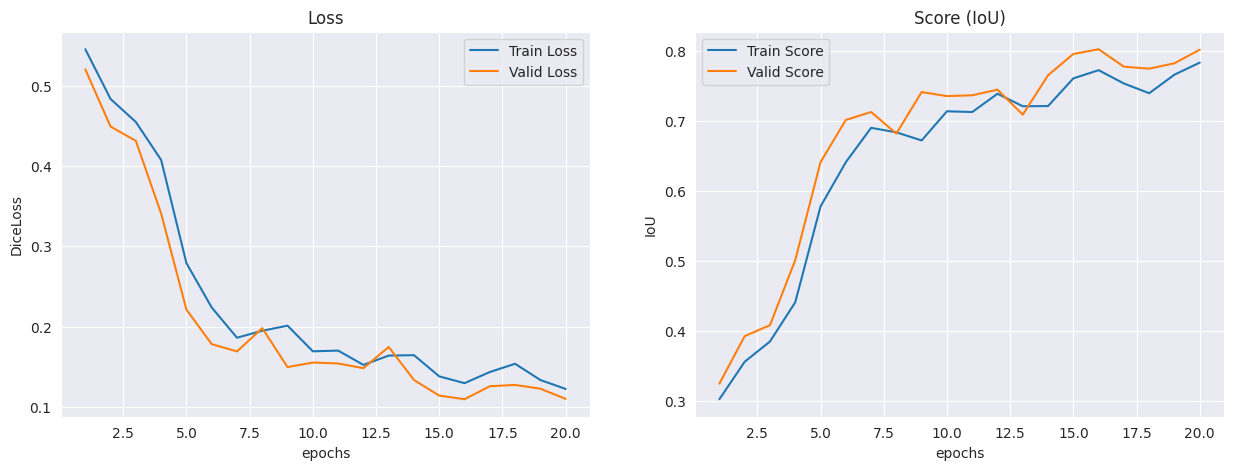

In [ ]:
import seaborn as sns

plt.figure(1)
plt.figure(figsize=(15,5))
sns.set_style(style="darkgrid")
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1,num_epochs+1), y=total_train_loss, label="Train Loss")
sns.lineplot(x=range(1,num_epochs+1), y=total_valid_loss, label="Valid Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("DiceLoss")

plt.subplot(1, 2, 2)
sns.lineplot(x=range(1,num_epochs+1), y=total_train_score, label="Train Score")
sns.lineplot(x=range(1,num_epochs+1), y=total_valid_score, label="Valid Score")
plt.title("Score (IoU)")
plt.xlabel("epochs")
plt.ylabel("IoU")
plt.show()

精度が向上していることが分かります．これは機械学習においてはモデルの学習が進み，より汎用化性能（予測性能）が増して行っていることを意味します．

こちらでは，matplotlibに加え，seabornを使用して描画しています．

⑤ 推論

次に、作成した学習したモデルを利用して、実際のモデルによるセマンティックセグメンテーションの結果を表示してみましょう。

まず作成したモデルを読み込みます。load_ckpメソッドにより，先ほどの学習にてbest_model_pathに保存したパラメータを読み込んでいます．

In [ ]:
model, optimizer, start_epoch, valid_loss_min = load_ckp(best_model_path, model, optimizer)

続いて入力画像と教師データ、モデルによる出力を表示する関数を用意し、出力を行います。

<ipython-input-49-016998f4b620>:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = torch.autograd.Variable(data, volatile=True).cuda()
<ipython-input-49-016998f4b620>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  mask = torch.autograd.Variable(mask, volatile=True).cuda()


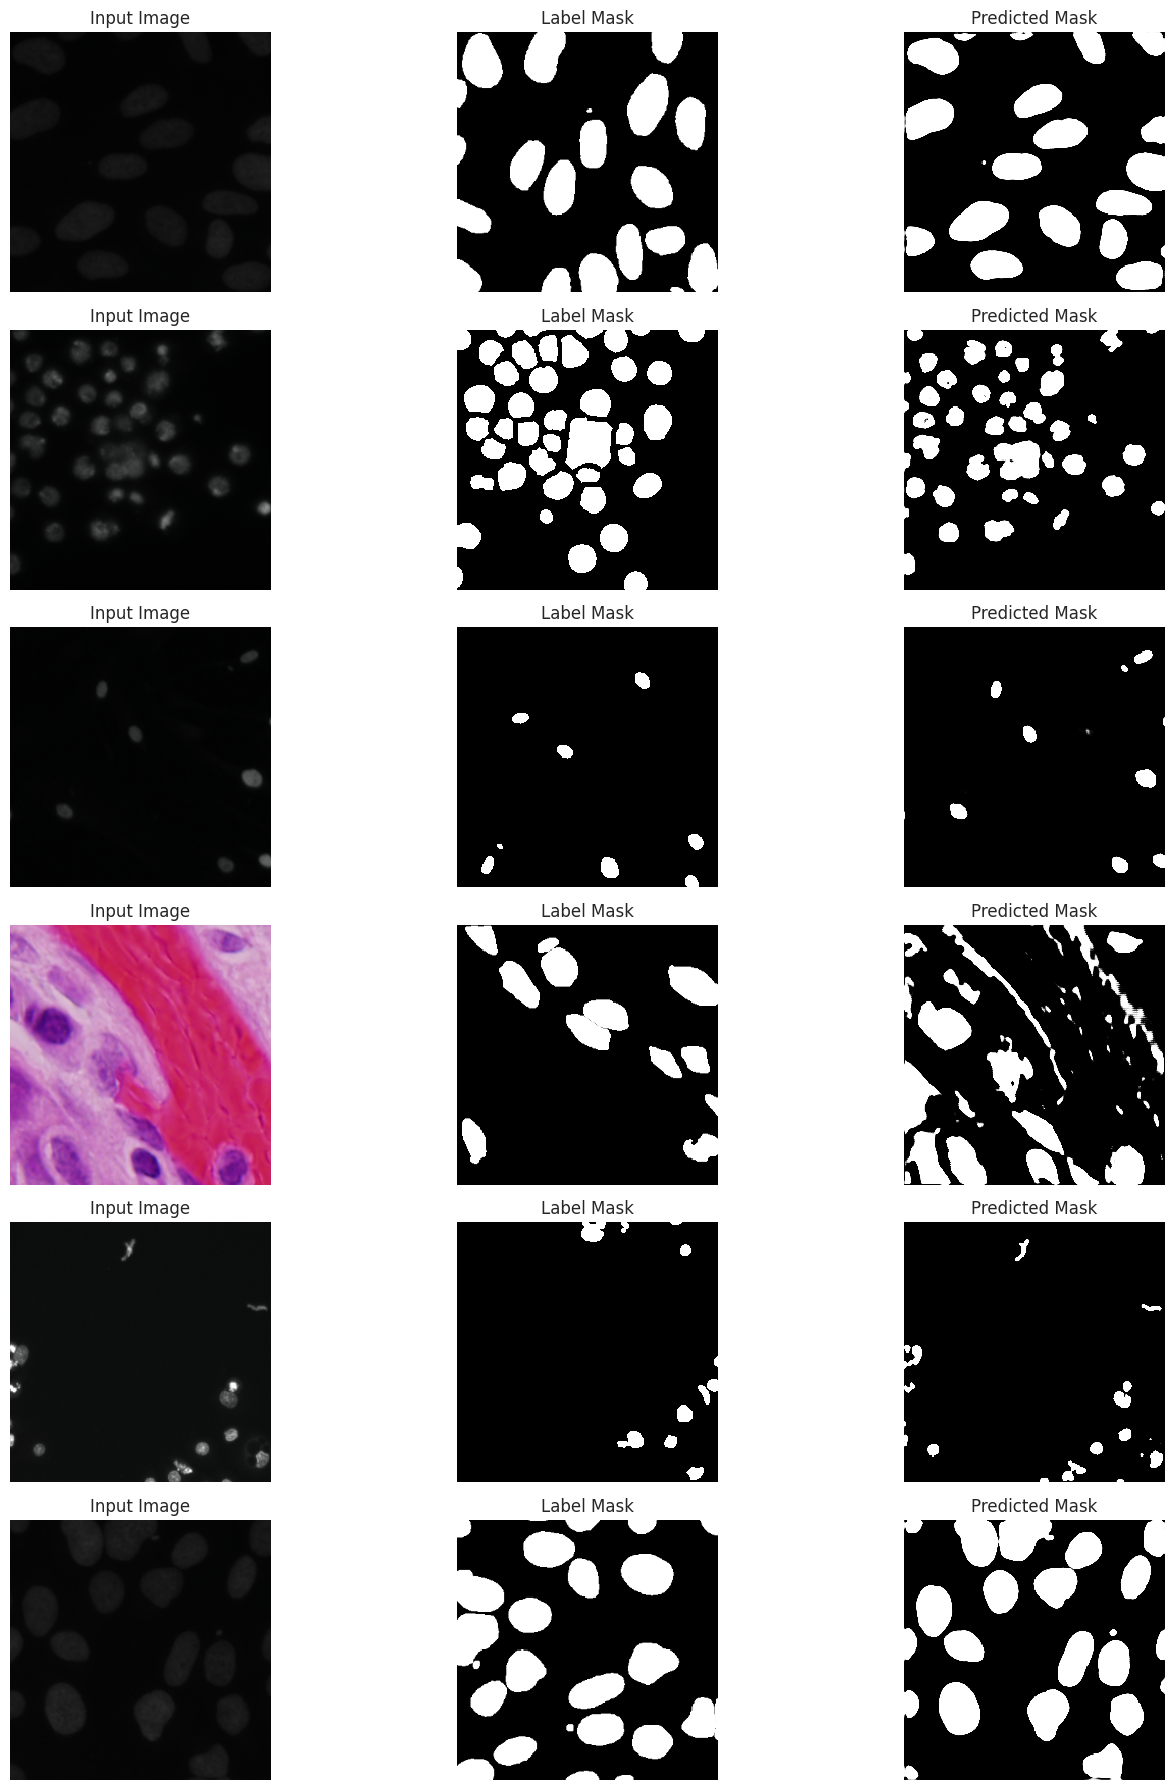

In [ ]:
def visualize_predict(model, n_images):
  figure, ax = plt.subplots(nrows=n_images, ncols=3, figsize=(15, 18))
  with torch.no_grad():
    for data,mask in val_loader:
        data = torch.autograd.Variable(data, volatile=True).cuda()
        mask = torch.autograd.Variable(mask, volatile=True).cuda()
        o = model(data)
        break
  for img_no in range(0, n_images):
    tm=o[img_no][0].data.cpu().numpy()
    img = data[img_no].data.cpu()
    msk = mask[img_no].data.cpu()
    img = format_image(img)
    msk = format_mask(msk)
    ax[img_no, 0].imshow(img)
    ax[img_no, 1].imshow(msk, interpolation="nearest", cmap="gray")
    ax[img_no, 2].imshow(tm, interpolation="nearest", cmap="gray")
    ax[img_no, 0].set_title("Input Image")
    ax[img_no, 1].set_title("Label Mask")
    ax[img_no, 2].set_title("Predicted Mask")
    ax[img_no, 0].set_axis_off()
    ax[img_no, 1].set_axis_off()
    ax[img_no, 2].set_axis_off()
  plt.tight_layout()
  plt.show()

visualize_predict(model, 6)

以上の結果を確認してみます．

Label Mask(教師データ)とPredicted Mask(モデル予測データ)を比較すると完全に等しくはなりませんが，モデルは比較的教師データに近いセグメンテーションをしていることがわかります．U-Netはピクセルごとの画像の濃淡を元にセグメンテーションしているので，教師データより細かいセグメンテーションを行なっていることも分かるかと思います．また，今回用いた学習データは数百枚のトレーニングデータしか用いておらず，（タスクにもよりますが）CNNなどで必要となるトレーニングデータの量と比べるととても少ないと感じられると思いますが，実際にデータ数が少ない時にも有用な方法です．
作成したモデルは保存していますので，このモデル再使用することでお手持ちの別の画像にもセグメンテーションをすることができますので，是非色々試して考察を行なって頂ければ幸いです．